# vLife Virtusa

## Patient Classification based on BioMechanical Features

## Usecase Description

### Classification of Patients based on BioMechanical Features

###### Solution to build a classification model in order to classifying patients as belonging to one out of three categories: Normal (100 patients), Disk Hernia (60 patients) or Spondylolisthesis (150 patients).Dataset consist of biomechnaical features having inclination,radius and angle for pelvis,lumber spine and Spondylolisthesis.Model used is Voting classifer for classifying patients.

### Data Source 
Data for this Usecase can be found [here](http://archive.ics.uci.edu/ml/datasets/vertebral+column#:~:text=Each%20patient%20is%20represented%20in,radius%20and%20grade%20of%20spondylolisthesis.)

## Dataset Description
##### Field Descriptions:

Each patient is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (each one is a column):

 - pelvic incidence
 - pelvic tilt
 - lumbar lordosis angle
 - sacral slope
 - pelvic radius
 - grade of spondylolisthesis

### Import Necessary Packages 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling as pp

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# NN models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
data = pd.read_csv("../input/biomechanical-features-of-orthopedic-patients/column_3C_weka.csv")

In [5]:
data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


### Data Wrangling (EDA)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
pelvic_incidence            310 non-null float64
pelvic_tilt                 310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
class                       310 non-null object
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [7]:
data.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [8]:
print('Rows     :',data.shape[0])
print('Columns  :',data.shape[1])
print('\nFeatures :\n     :',data.columns.tolist())
print('\nMissing values    :',data.isnull().values.sum())
print('\nUnique values :  \n',data.nunique())

Rows     : 310
Columns  : 7

Features :
     : ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class']

Missing values    : 0

Unique values :  
 pelvic_incidence            310
pelvic_tilt                 310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         3
dtype: int64


In [9]:
data['class'].value_counts()

Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64

In [10]:
M = data[(data['class'] == 'Normal')]
B = data[(data['class'] == 'Hernia')]
K  = data[(data['class'] == 'Spondylolisthesis')]

trace = go.Bar(x = (len(M), len(B),len(K)), y = ['Normal','Hernia','Spondylolisthesis'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['red','green','blue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of target variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

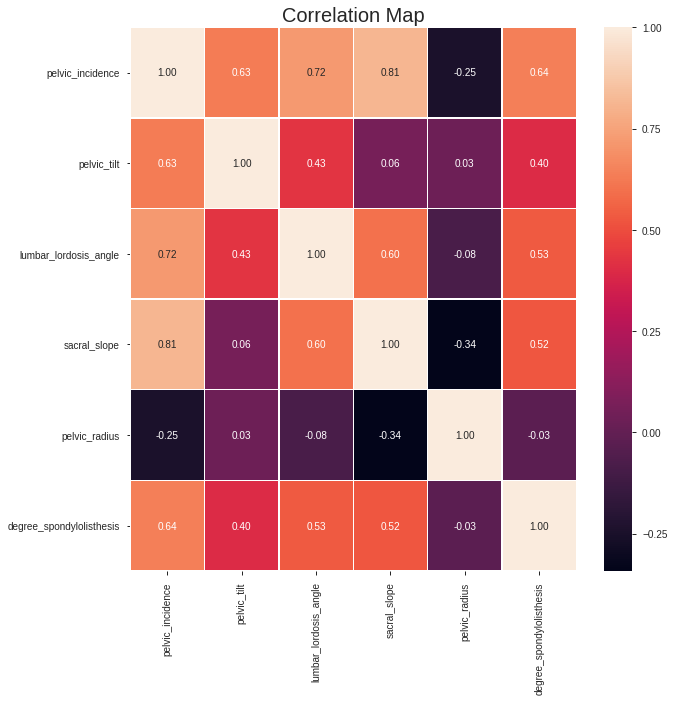

In [11]:
#correlation map
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, linewidth=".5", fmt=".2f", ax = ax)
plt.title("Correlation Map",fontsize=20)
plt.show()

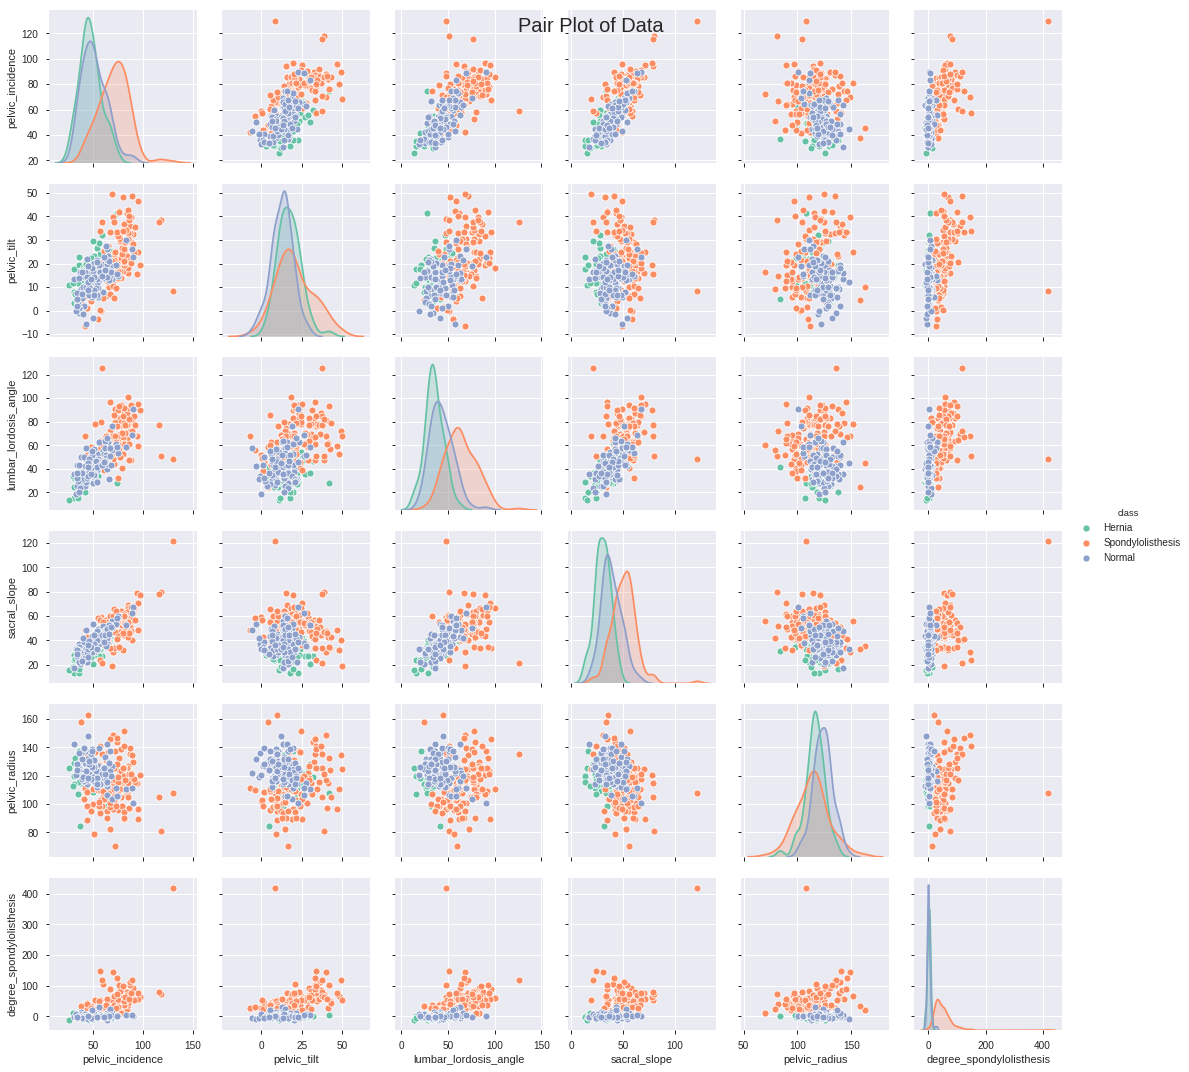

In [12]:
sns.pairplot(data=data,hue="class",palette="Set2")
plt.suptitle("Pair Plot of Data",fontsize=20)
plt.show() 

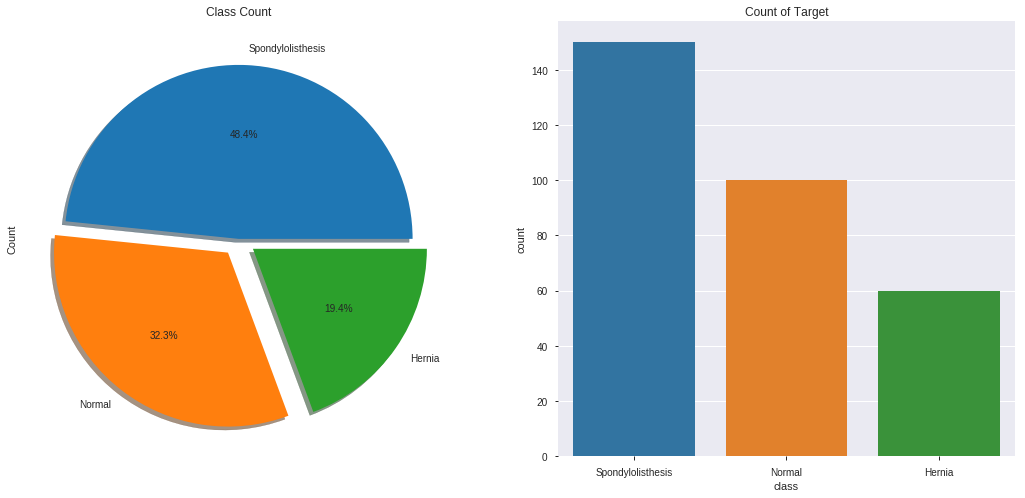

In [13]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['class'].value_counts().plot.pie(explode=[0,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Class Count')
ax[0].set_ylabel('Count')
sns.countplot('class',data=data,ax=ax[1],order=data['class'].value_counts().index)
ax[1].set_title('Count of Target')
plt.show()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
pelvic_incidence            310 non-null float64
pelvic_tilt                 310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
class                       310 non-null object
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


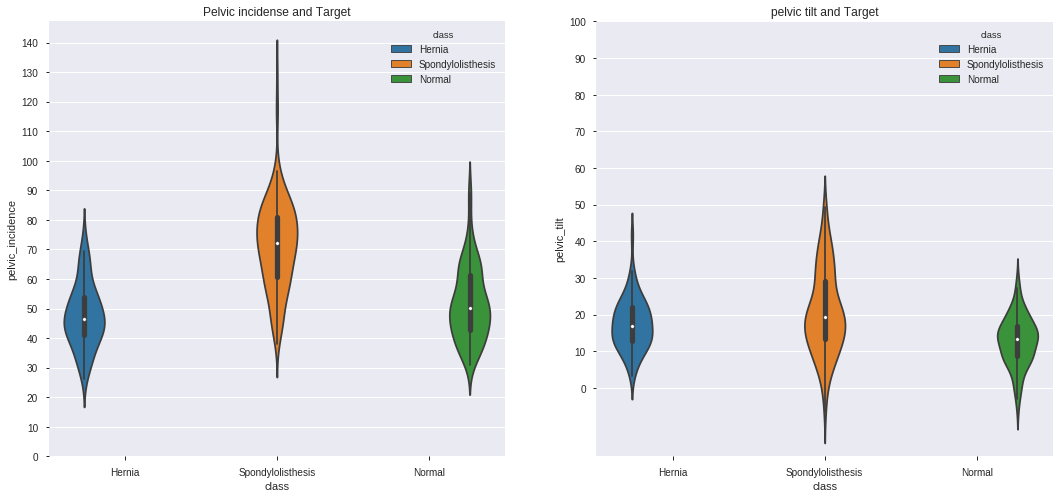

In [15]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("class","pelvic_incidence", hue="class", data=data,ax=ax[0])
ax[0].set_title('Pelvic incidense and Target')
ax[0].set_yticks(range(0,150,10))
sns.violinplot("class","pelvic_tilt", hue="class", data=data,ax=ax[1])
ax[1].set_title('pelvic tilt and Target')
ax[1].set_yticks(range(0,110,10))
plt.show()

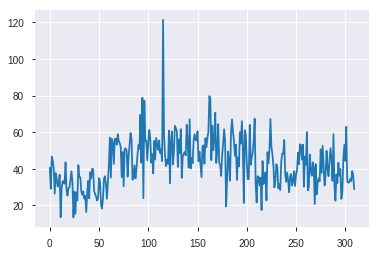

In [16]:
plt.plot(data['sacral_slope'])
plt.show()

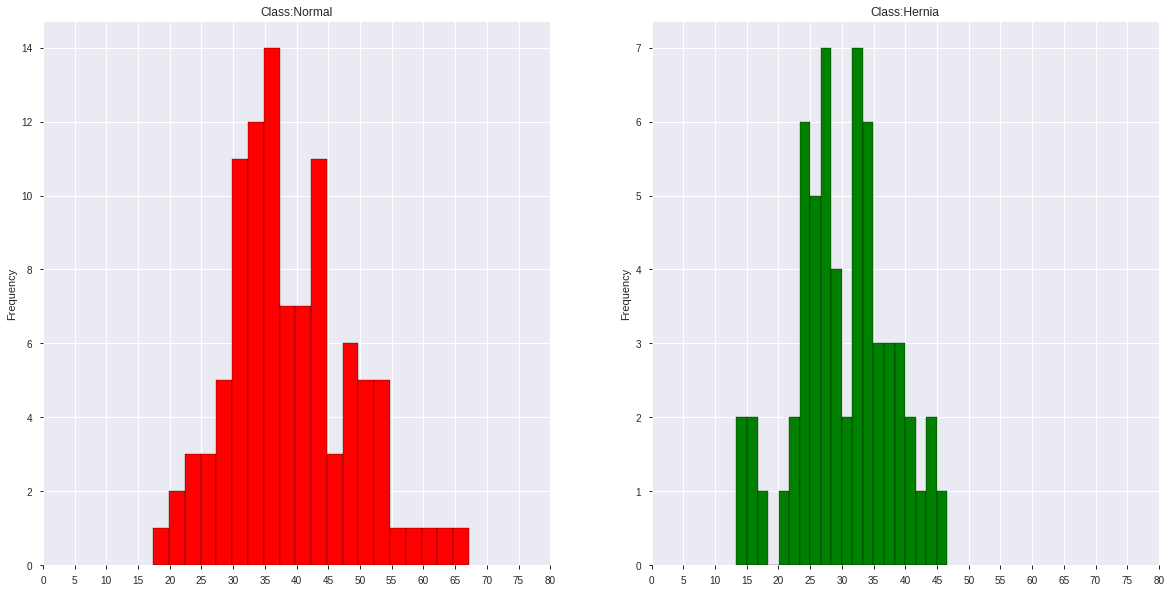

In [17]:
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['class']=='Normal'].sacral_slope.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Class:Normal')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['class']=='Hernia'].sacral_slope.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Class:Hernia')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

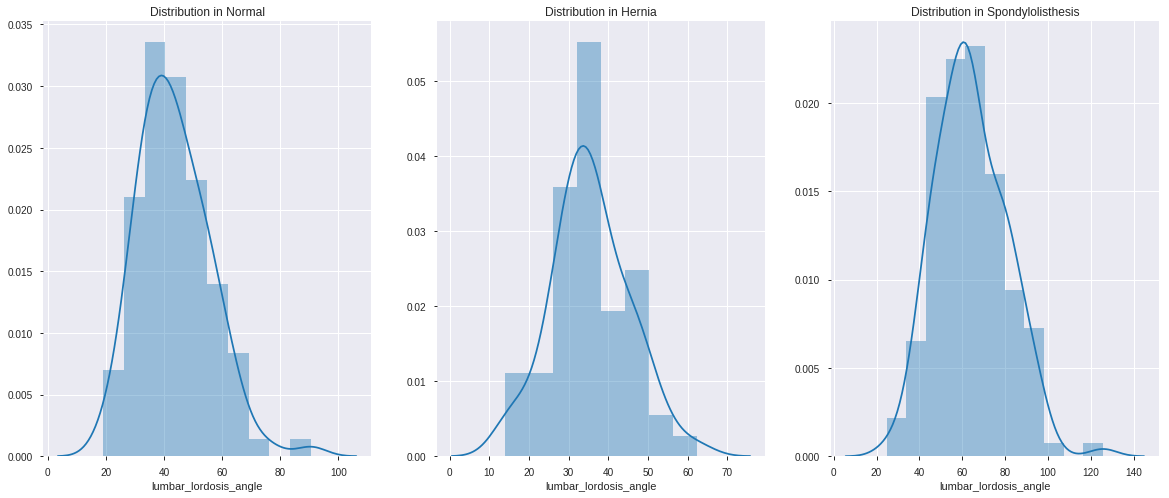

In [18]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['class']=='Normal'].lumbar_lordosis_angle,ax=ax[0])
ax[0].set_title('Distribution in Normal')
sns.distplot(data[data['class']=='Hernia'].lumbar_lordosis_angle,ax=ax[1])
ax[1].set_title('Distribution in Hernia')
sns.distplot(data[data['class']=='Spondylolisthesis'].lumbar_lordosis_angle,ax=ax[2])
ax[2].set_title('Distribution in Spondylolisthesis')
plt.show()

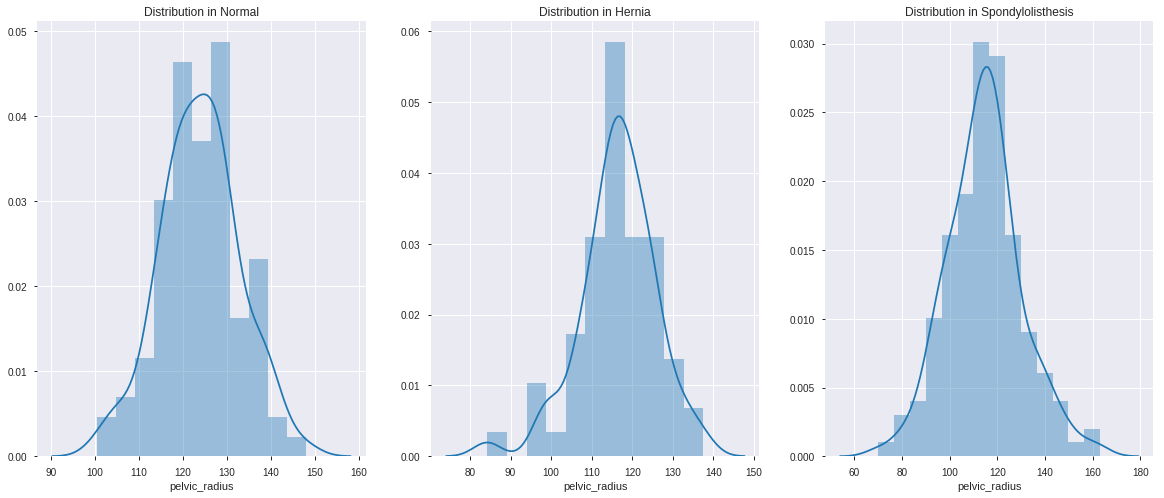

In [19]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['class']=='Normal'].pelvic_radius,ax=ax[0])
ax[0].set_title('Distribution in Normal')
sns.distplot(data[data['class']=='Hernia'].pelvic_radius,ax=ax[1])
ax[1].set_title('Distribution in Hernia')
sns.distplot(data[data['class']=='Spondylolisthesis'].pelvic_radius,ax=ax[2])
ax[2].set_title('Distribution in Spondylolisthesis')
plt.show()

### Predictive Models

In [20]:
def get_X_and_y(dataset, target_name):
    X=dataset.drop(target_name, axis=1)
    y=dataset[target_name]
    sc = StandardScaler()
    X=sc.fit_transform(X)    
    return X, y

In [21]:
X,y = get_X_and_y(data,target_name='class')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Model Selection

In [23]:
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['LogReg','XGBClassifier','KNN','DecisionTreeClassifier','RandomForestClassifier Tree','GradientBoostingClassifier','RidgeClassifier','ExtraTreesClassifier']
models=[LogisticRegression(),XGBClassifier(),KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(n_estimators=100),GradientBoostingClassifier(n_estimators=100),RidgeClassifier(),ExtraTreeClassifier()]
for i in models:
    model = i
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2


,CV Mean,Std
LogReg,0.848052,0.104071
XGBClassifier,0.852597,0.088900
KNN,0.778571,0.096819
DecisionTreeClassifier,0.792857,0.075199
RandomForestClassifier Tree,0.852597,0.084839
GradientBoostingClassifier,0.828788,0.089226
RidgeClassifier,0.810390,0.104486
ExtraTreesClassifier,0.714719,0.082409


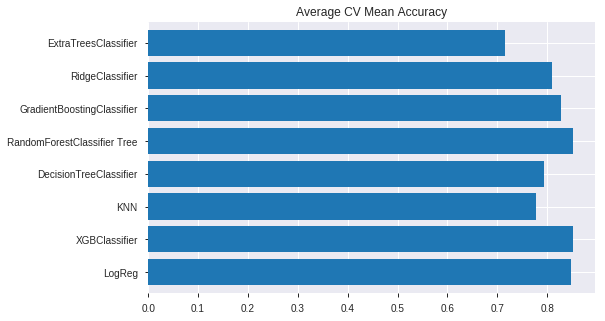

In [24]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

### Hyper Param Tuning for Random Forest classifier

In [25]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X_train,y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   32.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



0.8617511520737328
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


Accuracy : 0.8387096774193549
                   precision    recall  f1-score   support

           Hernia       0.62      0.59      0.61        17
           Normal       0.70      0.78      0.74        27
Spondylolisthesis       1.00      0.96      0.98        49

         accuracy                           0.84        93
        macro avg       0.78      0.78      0.77        93
     weighted avg       0.84      0.84      0.84        93



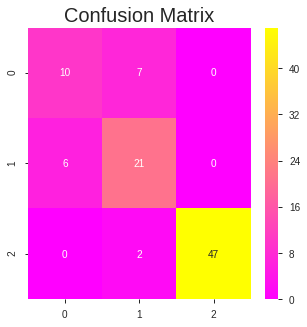

In [26]:
# creating a model
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
# feeding the training set into the model
model.fit(X_train, y_train)

# predicting the test set results
y_pred = model.predict(X_test)

# Calculating the accuracies
print("Accuracy :", model.score(X_test, y_test))

# classification report
cr = classification_report(y_test, y_pred)
print(cr)

# confusion matrix 
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, cmap = 'spring')
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

### Hyper Param Tuning for Logistic Regression

In [27]:
log_clf = LogisticRegression(random_state = 42)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The best parameters for using this model is {'C': 10, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    3.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Accuracy : 0.8709677419354839
                   precision    recall  f1-score   support

           Hernia       0.71      0.71      0.71        17
           Normal       0.77      0.85      0.81        27
Spondylolisthesis       1.00      0.94      0.97        49

         accuracy                           0.87        93
        macro avg       0.82      0.83      0.83        93
     weighted avg       0.88      0.87      0.87        93



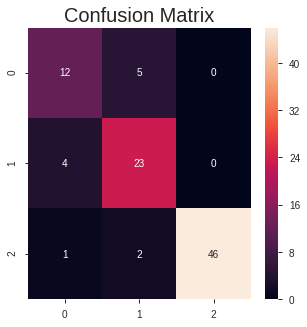

In [28]:
# creating a model
model_lr = LogisticRegression(C= 10,penalty='l2')
# feeding the training set into the model
model_lr.fit(X_train, y_train)

# predicting the test set results
y_pred = model_lr.predict(X_test)

# Calculating the accuracies
print("Accuracy :", model_lr.score(X_test, y_test))

# classification report
cr = classification_report(y_test, y_pred)
print(cr)

# confusion matrix 
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

### Predictive Modelling with Voting Classifier

The accuracy for ensembled model is: 0.9539170506912442
The cross validated score is 0.8381987577639751
                   precision    recall  f1-score   support

           Hernia       0.73      0.65      0.69        17
           Normal       0.68      0.78      0.72        27
Spondylolisthesis       0.96      0.92      0.94        49

         accuracy                           0.83        93
        macro avg       0.79      0.78      0.78        93
     weighted avg       0.84      0.83      0.83        93



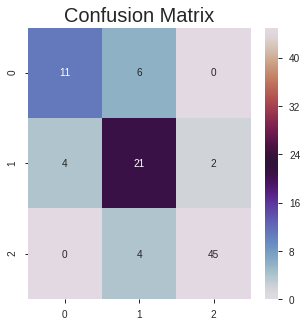

In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn import svm
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(X_train,y_train)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(X_train,y_train))
cross=cross_val_score(ensemble_lin_rbf,X_train,y_train, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())
y_pred_voting = ensemble_lin_rbf.predict(X_test)

# classification report
cr = classification_report(y_test, y_pred_voting)
print(cr)

# confusion matrix 
cm = confusion_matrix(y_test, y_pred_voting)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True,cmap='twilight')
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

In [30]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.7190217391304347


In [31]:
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8247412008281574


In [32]:
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.8336697722567287


### Hyper Param Tuning for XGB Classifier

In [33]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softprob',
                    silent=True, nthread=1)

In [34]:
CV_xgb_clf = GridSearchCV(estimator = xgb, param_grid = params , scoring = 'accuracy', verbose = 1, n_jobs = -1)

# Here we go
CV_xgb_clf.fit(X_train, y_train)
best_parameters = CV_xgb_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  1.8min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



The best parameters for using this model is {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}


Accuracy : 0.8064516129032258
                   precision    recall  f1-score   support

           Hernia       0.53      0.47      0.50        17
           Normal       0.66      0.78      0.71        27
Spondylolisthesis       1.00      0.94      0.97        49

         accuracy                           0.81        93
        macro avg       0.73      0.73      0.73        93
     weighted avg       0.81      0.81      0.81        93



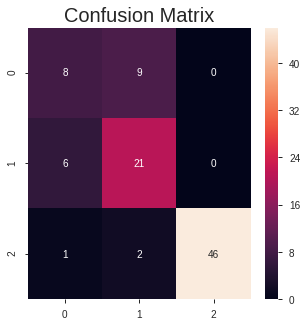

In [35]:
# creating a model
model_xgb_ = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softprob',
                    silent=True, nthread=1,colsample_bytree=0.6,gamma=0.5,max_depth = 5,min_child_weight=1,subsample=0.6)
# feeding the training set into the model
model_xgb_.fit(X_train, y_train)

# predicting the test set results
y_pred = model_xgb_.predict(X_test)

# Calculating the accuracies
print("Accuracy :", model_xgb_.score(X_test, y_test))

# classification report
cr = classification_report(y_test, y_pred)
print(cr)

# confusion matrix 
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

### Predictive Classifier with Keras ANN

In [36]:
model = Sequential()
model.add(Dense(units=32,input_dim = 6,kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(rate=0.5))

# Adding the output layer
model.add(Dense(units=3, kernel_initializer='glorot_uniform', activation='softmax'))

# Compiling the ANN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 6,691
Trainable params: 6,691
Non-trainable params: 0
____________________________________________________

In [37]:
lb = LabelEncoder()
y_train  = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [38]:
from keras.utils import to_categorical
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

history = model.fit(X_train, y_train_ohe, batch_size=16, epochs=100, validation_data=(X_test, y_test_ohe))

Train on 217 samples, validate on 93 samples
Epoch 1/100
217/217 [==============================] - 1s 2ms/step - loss: 1.0671 - accuracy: 0.4194 - val_loss: 0.9496 - val_accuracy: 0.5484
Epoch 2/100
217/217 [==============================] - 0s 172us/step - loss: 0.9670 - accuracy: 0.5392 - val_loss: 0.8446 - val_accuracy: 0.6344
Epoch 3/100
217/217 [==============================] - 0s 170us/step - loss: 0.8722 - accuracy: 0.5714 - val_loss: 0.7738 - val_accuracy: 0.6667
Epoch 4/100
217/217 [==============================] - 0s 169us/step - loss: 0.8075 - accuracy: 0.6359 - val_loss: 0.7216 - val_accuracy: 0.6774
Epoch 5/100
217/217 [==============================] - 0s 163us/step - loss: 0.7190 - accuracy: 0.7143 - val_loss: 0.6852 - val_accuracy: 0.6989
Epoch 6/100
217/217 [==============================] - 0s 162us/step - loss: 0.6826 - accuracy: 0.7419 - val_loss: 0.6576 - val_accuracy: 0.7097
Epoch 7/100
217/217 [==============================] - 0s 165us/step - loss: 0.6349 - a

Epoch 57/100
217/217 [==============================] - 0s 152us/step - loss: 0.2787 - accuracy: 0.8618 - val_loss: 0.4478 - val_accuracy: 0.8387
Epoch 58/100
217/217 [==============================] - 0s 152us/step - loss: 0.2643 - accuracy: 0.8986 - val_loss: 0.4478 - val_accuracy: 0.8387
Epoch 59/100
217/217 [==============================] - 0s 159us/step - loss: 0.2913 - accuracy: 0.8802 - val_loss: 0.4583 - val_accuracy: 0.8387
Epoch 60/100
217/217 [==============================] - 0s 154us/step - loss: 0.2596 - accuracy: 0.9078 - val_loss: 0.4376 - val_accuracy: 0.8387
Epoch 61/100
217/217 [==============================] - 0s 153us/step - loss: 0.2669 - accuracy: 0.8940 - val_loss: 0.4360 - val_accuracy: 0.8387
Epoch 62/100
217/217 [==============================] - 0s 162us/step - loss: 0.2807 - accuracy: 0.8664 - val_loss: 0.4320 - val_accuracy: 0.8495
Epoch 63/100
217/217 [==============================] - 0s 164us/step - loss: 0.2697 - accuracy: 0.8756 - val_loss: 0.4459 -

In [41]:
# evaluate the keras model
_, accuracy_train = model.evaluate(X_train, y_train_ohe)
_, accuracy = model.evaluate(X_test, y_test_ohe)
print('Accuracy for Test Data: %.2f' % (accuracy*100))

93/93 [==============================] - 0s 64us/step
Accuracy for Test Data: 82.80


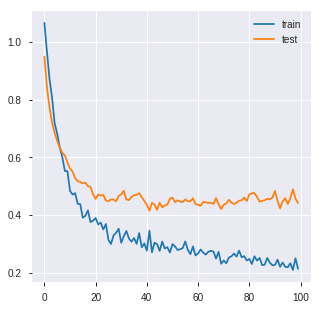

In [40]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## END